We'll use the famous diabetes dataset for showing how to do variable importance in various ways.

# Load the dataset

Luckily there's the handy [load_diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) function in sklearn.
More info [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset)

In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd

# Load the dataset
diabetes = load_diabetes()

# Build X and y variables. The features are converted explicitly to pandas df
X = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

# Display the first few rows
print(X.head())

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  


# Simple model

To be later investigated. We are not doing train/val split for this exercise, to keep stuff simple.

In [2]:
# Initialize and train the model
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Printing the (bloated) error on train set
print(f"RF train performance (squared error): {rf.score(X, y):.3f}")

RF train performance (squared error): 0.920


# Embedded feature importance from random forest

In [3]:
# Let's just extract the info from the trained model
rf_feature_importance = pd.Series(rf.feature_importances_, index = X.columns)

# Sort the values
rf_feature_importance.sort_values(ascending=False, inplace = True)
print(rf_feature_importance)

s5     0.315629
bmi    0.276249
bp     0.087085
s6     0.070775
age    0.057496
s2     0.055368
s3     0.051191
s1     0.047251
s4     0.027056
sex    0.011901
dtype: float64


# Permutation test


A few links to docs and demos:

* [demo permutation importance](
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)
* [permutation_importance()](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) function from sklearn
* [extra info](https://scikit-learn.org/stable/modules/permutation_importance.html) on how to interpret permutation importance

In [5]:
from sklearn.inspection import permutation_importance

# Permutation test, 30 repeats
result = permutation_importance(rf, X, y, n_repeats=30)

# Extract the importances, then sort it
perm_importance = pd.Series(result.importances_mean, index = X.columns)
perm_importance.sort_values(ascending=False, inplace=True)
print(perm_importance)

bmi    0.483500
s5     0.473739
bp     0.132231
s6     0.087883
age    0.076843
s3     0.074237
s2     0.063852
s1     0.052426
s4     0.029342
sex    0.023151
dtype: float64


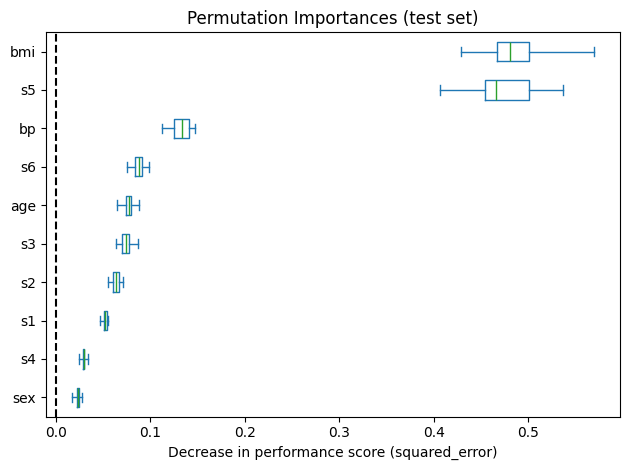

In [6]:
# Doing a box plot. First, sort by mean value, and take note of the new order
sorted_importances_idx = result.importances_mean.argsort()

# Now we create a pandas df with the specified order of features, and all
# the results from all the repetitions
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# There's a boxplot embedded in pandas object, let's just use that
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in performance score (squared_error)")
ax.figure.tight_layout()

# Shapley values, with SHAP

* [SHAP library](https://shap.readthedocs.io/en/latest/index.html), with a [nice intro/demo](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)
* [guide to shapley values](https://www.geeksforgeeks.org/shap-a-comprehensive-guide-to-shapley-additive-explanations/)


 93%|=================== | 410/442 [00:11<00:00]       

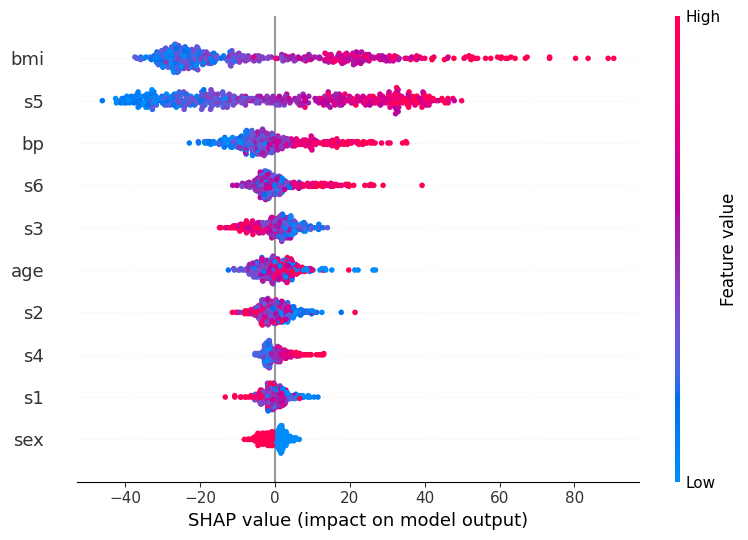

In [7]:
import shap
explainer = shap.Explainer(rf, X)
shap_values = explainer(X, check_additivity = False)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

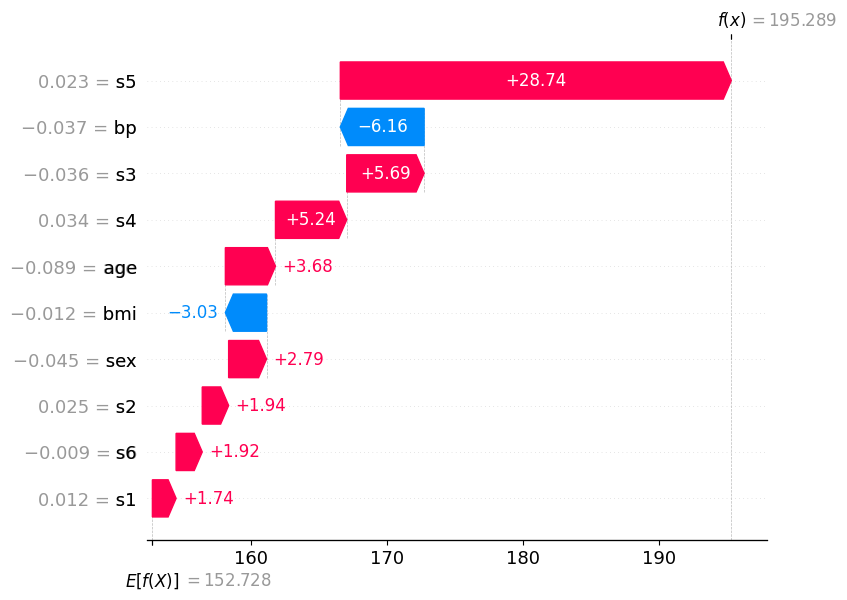

In [8]:
# we want to focus on, for example, the third individual
sample_ind = 3

# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind])

In [ ]:
# For reference, the total average
y.mean()

np.float64(152.13348416289594)